##FD schemes convergece investigation using 2D wave equation

In [581]:
%load_ext autoreload
%autoreload 2
from sympy import symbols, init_printing, simplify, solve, srepr, Add, Symbol, Integer, Float, pi, cos, sin, Rational
from sympy import IndexedBase, Eq
from mako.template import Template
from mako.lookup import TemplateLookup
from mako.runtime import Context
from StringIO import StringIO
from grid import *
init_printing()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [582]:
x, y, t, lam, mu, beta, a, b, h, dt, dimx, dimy, Vs = symbols('x y t lambda mu beta a b h dt dimx dimy Vs')
Txx = IndexedBase('Txx')
Tyy = IndexedBase('Tyy')
Txy = IndexedBase('Txy')
U = IndexedBase('U')
V = IndexedBase('V')

In [583]:
grid = StaggeredGrid2D()
grid.assign_grid_size([h,h],dt)
grid.assign_stress_fields(Txx,Tyy,Txy)
grid.assign_velocity_fields(U,V)
grid.assign_dimensions([dimx, dimy])

###Eigenmode functions (as initial condition and analytical solution)

$U = acos(\pi x)sin(\pi y)cos(at)$<br>
$V = -asin(\pi x)cos(\pi y)cos(at)$<br>
$T_{xx} = -bsin(\pi x)sin(\pi y)sin(at)$<br>
$T_{yy} = bsin(\pi x)sin(\pi y)sin(at)$<br>
$T_{xy} = T_{yx} = 0$<br>
where $a=\sqrt 2 \pi V_s\space \space b=2\pi\mu$

In [584]:
a = 2**(0.5)*pi*Vs
b = 2*pi*mu
U_func = a*cos(pi*x)*sin(pi*y)*cos(a*t)
V_func = -a*sin(pi*x)*cos(pi*y)*cos(a*t)
Txx_func = -b*sin(pi*x)*sin(pi*y)*sin(a*t)
Tyy_func = b*sin(pi*x)*sin(pi*y)*sin(a*t)
Txy_func = Float(0)

In [585]:
grid.assign_function(U, U_func)
grid.assign_function(V, V_func)
grid.assign_function(Txx, Txx_func)
grid.assign_function(Tyy, Tyy_func)
grid.assign_function(Txy, Txy_func)

###Calculate FD approximation of derivatives

In [586]:
grid.calc_derivatives()

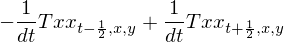

In [587]:
grid.Dt[Txx]

###PDEs
#####momentum equations
$\partial_tU = b(\partial_xT_{xx}+\partial_yT_{xy})$<br>
$\partial_tV = b(\partial_xT_{xy}+\partial_yT_{yy})$<br>
#####stress-strain equations
$\partial_tT_{xx} = (\lambda+2\mu)\partial_xU + \lambda\partial_yV $<br>
$\partial_tT_{yy} = (\lambda+2\mu)\partial_yV + \lambda\partial_xU $<br>
$\partial_tT_{xy} = \mu(\partial_yU + \partial_xV)$<br>

In [588]:
# momentum equations
eq1 = Eq(grid.Dt[U], beta*(grid.Dx[Txx] + grid.Dy[Txy]))
eq2 = Eq(grid.Dt[V], beta*(grid.Dx[Txy] + grid.Dy[Tyy]))
# stress-strain equations
eq3 = Eq(grid.Dt[Txx], (lam + 2*mu)*grid.Dx[U] + lam*grid.Dy[V])
eq4 = Eq(grid.Dt[Tyy], (lam + 2*mu)*grid.Dy[V] + lam*grid.Dx[U])
eq5 = Eq(grid.Dt[Txy], mu*(grid.Dy[U]+grid.Dx[V]))

In [589]:
grid.assign_fd(U, solve(eq1,U[t+hf,x,y])[0].subs(t,t+hf))
grid.assign_fd(V, solve(eq2,V[t+hf,x,y])[0].subs(t,t+hf))
grid.assign_fd(Txx, solve(eq3,Txx[t+hf,x,y])[0].subs(t,t+hf))
grid.assign_fd(Tyy, solve(eq4,Tyy[t+hf,x,y])[0].subs(t,t+hf))
grid.assign_fd(Txy, solve(eq5,Txy[t+hf,x,y])[0].subs(t,t+hf))

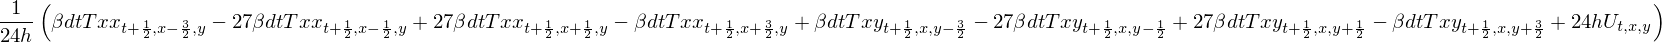

In [590]:
grid.fd[U]

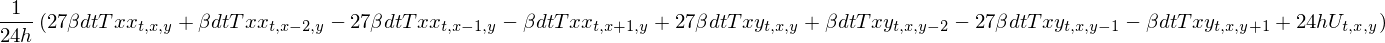

In [591]:
grid.fd_shifted[U]

In [592]:
grid.stress_loop()

u'#pragma omp for\nfor(int x=2;x<dimx - 2;++x){\n    for(int y=2;y<dimy - 2;++y){\n    \tTxx[t1][x][y]=(1.0F/24.0F)*(27*dt*lambda*U[t][x][y] + dt*lambda*U[t][x - 2][y] - 27*dt*lambda*U[t][x - 1][y] - dt*lambda*U[t][x + 1][y] + 27*dt*lambda*V[t][x][y] + dt*lambda*V[t][x][y - 2] - 27*dt*lambda*V[t][x][y - 1] - dt*lambda*V[t][x][y + 1] + 54*dt*mu*U[t][x][y] + 2*dt*mu*U[t][x - 2][y] - 54*dt*mu*U[t][x - 1][y] - 2*dt*mu*U[t][x + 1][y] + 24*h*Txx[t][x][y])/h;\n\t\tTyy[t1][x][y]=(1.0F/24.0F)*(27*dt*lambda*U[t][x][y] + dt*lambda*U[t][x - 2][y] - 27*dt*lambda*U[t][x - 1][y] - dt*lambda*U[t][x + 1][y] + 27*dt*lambda*V[t][x][y] + dt*lambda*V[t][x][y - 2] - 27*dt*lambda*V[t][x][y - 1] - dt*lambda*V[t][x][y + 1] + 54*dt*mu*V[t][x][y] + 2*dt*mu*V[t][x][y - 2] - 54*dt*mu*V[t][x][y - 1] - 2*dt*mu*V[t][x][y + 1] + 24*h*Tyy[t][x][y])/h;\n\t\tTxy[t1][x][y]=(1.0F/24.0F)*(27*dt*mu*U[t][x][y] + dt*mu*U[t][x][y - 2] - 27*dt*mu*U[t][x][y - 1] - dt*mu*U[t][x][y + 1] + 27*dt*mu*V[t][x][y] + dt*mu*V[t][x - 2][y] 

In [593]:
grid.velocity_loop()

u'#pragma omp for\nfor(int x=2;x<dimx - 2;++x){\n    for(int y=2;y<dimy - 2;++y){\n    \tU[t1][x][y]=(1.0F/24.0F)*(27*beta*dt*Txx[t1][x][y] + beta*dt*Txx[t1][x - 2][y] - 27*beta*dt*Txx[t1][x - 1][y] - beta*dt*Txx[t1][x + 1][y] + 27*beta*dt*Txy[t1][x][y] + beta*dt*Txy[t1][x][y - 2] - 27*beta*dt*Txy[t1][x][y - 1] - beta*dt*Txy[t1][x][y + 1] + 24*h*U[t1][x][y])/h;\n\t\tV[t1][x][y]=(1.0F/24.0F)*(27*beta*dt*Txy[t1][x][y] + beta*dt*Txy[t1][x - 2][y] - 27*beta*dt*Txy[t1][x - 1][y] - beta*dt*Txy[t1][x + 1][y] + 27*beta*dt*Tyy[t1][x][y] + beta*dt*Tyy[t1][x][y - 2] - 27*beta*dt*Tyy[t1][x][y - 1] - beta*dt*Tyy[t1][x][y + 1] + 24*h*V[t1][x][y])/h;\n    }\n}\n'

##boundary conditions

###get the second order FD approximation in space

In [594]:
grid.stress_bc()

u'    // update ghost cells for boundary conditions\n    #pragma omp for\n    for(int x=0;x<dimx;x++){\n      // boundary y=2\n      Txx[t1][x][1] = -Txx[t1][x][3];\n      Txx[t1][x][2] = 0.0;\n      Tyy[t1][x][1] = -Tyy[t1][x][3];\n      Tyy[t1][x][2] = 0.0;\n      Txy[t1][x][0] = -Txy[t1][x][3];\n      Txy[t1][x][1] = -Txy[t1][x][2];\n      // boundary y=dimy+2\n      Txx[t1][x][dimy-2] = -Txx[t1][x][dimy-4];\n      Txx[t1][x][dimy-3] = 0.0;\n      Tyy[t1][x][dimy-2] = -Tyy[t1][x][dimy-4];\n      Tyy[t1][x][dimy-3] = 0.0;\n      Txy[t1][x][dimy-2] = -Txy[t1][x][dimy-5];\n      Txy[t1][x][dimy-3] = -Txy[t1][x][dimy-4];\n    }\n    // update ghost cells for boundary conditions\n    #pragma omp for\n    for(int y=0;y<dimy;y++){\n      // boundary x=2\n      Txx[t1][1][y] = -Txx[t1][3][y];\n      Txx[t1][2][y] = 0.0;\n      Tyy[t1][1][y] = -Tyy[t1][3][y];\n      Tyy[t1][2][y] = 0.0;\n      Txy[t1][0][y] = -Txy[t1][3][y];\n      Txy[t1][1][y] = -Txy[t1][2][y];\n      // boundary x=dimx+2\

In [595]:
# these are used to calculate U and V beyond boundary
Txx_expr = (lam + 2*mu)*grid.Dx_2[U] + lam*grid.Dy_2[V]
Tyy_expr = (lam + 2*mu)*grid.Dy_2[V] + lam*grid.Dx_2[U]
Txy_expr = mu*(grid.Dy_2[U] + grid.Dx_2[V])

In [596]:
grid.assign_bc(V,1,0,solve(Tyy_expr, V[t,x,y-hf])[0].subs(y,y+hf))
grid.assign_bc(U,1,0,solve(Eq(Txy_expr.subs(y,y-hf),Txy_expr.subs(y,y+hf)), U[t,x,y-1])[0].subs(y,y+1))

In [597]:
grid.assign_bc(V,1,1,solve(Tyy_expr, V[t,x,y+hf])[0].subs(y,y-hf))
grid.assign_bc(U,1,1,solve(Eq(Txy_expr.subs(y,y-hf),Txy_expr.subs(y,y+hf)), U[t,x,y+1])[0].subs(y,y-1))

In [598]:
grid.assign_bc(U,0,0,solve(Txx_expr, U[t,x-hf,y])[0].subs(x,x+hf))
grid.assign_bc(V,0,0,solve(Eq(Txy_expr.subs(x,x-hf),Txy_expr.subs(x,x+hf)), V[t,x-1,y])[0].subs(x,x+1))

In [599]:
grid.assign_bc(U,0,1,solve(Txx_expr, U[t,x+hf,y])[0].subs(x,x-hf))
grid.assign_bc(V,0,1,solve(Eq(Txy_expr.subs(x,x-hf),Txy_expr.subs(x,x+hf)), V[t,x+1,y])[0].subs(x,x-1))

###output using templates

In [600]:
# write to template file
mylookup = TemplateLookup(directories=['templates/staggered','templates/'])
mytemplate = mylookup.get_template('staggered2d_tmpl.cpp')
buf = StringIO()
dict1 = {'time_period':2,'initialise':grid.initialise(),'stress_loop':grid.stress_loop(),'velocity_loop':grid.velocity_loop(),'stress_bc':grid.stress_bc(),'velocity_bc':grid.velocity_bc()}
ctx = Context(buf, **dict1)
mytemplate.render_context(ctx)
code = buf.getvalue()

In [601]:
# generate compilable C++ source code
f= open('test.cpp','w')
f.write(code)
f.close()

In [602]:
grid.velocity_bc()

u'    // update ghost cells for boundary conditions\n    #pragma omp for\n    for(int y=0;y<dimx;y++){\n      U[t1][1][y]=(lambda*U[t1][2][y] + lambda*V[t1][2][y] - lambda*V[t1][2][y - 1] + 2*mu*U[t1][2][y])/(lambda + 2*mu);\n      V[t1][1][y]=U[t1][1][y] - U[t1][1][y - 1] - U[t1][2][y] + U[t1][2][y - 1] + 2*V[t1][2][y] - V[t1][3][y];\n    }\n    // update ghost cells for boundary conditions\n    #pragma omp for\n    for(int y=0;y<dimx;y++){\n      test\n      test\n    }\n'

In [604]:
grid.bc[0][0][V].subs(x,1)